# Histograms of metric values for selected IR & GR

### imports, setup and loading data

In [1]:
import gc
import os
import warnings
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
sample_size = 24        # 24, 56
plots_dir = os.path.join('out', 'plots', f'n{sample_size}', 'histograms')
calculations_dir = os.path.join('out', 'calculations', f'n{sample_size}')

os.makedirs(plots_dir, exist_ok=True)
os.makedirs(calculations_dir, exist_ok=True)

metrics = {
    'acc_equality_diff.bin': 'Accuracy equality difference',
    'equal_opp_diff.bin': 'Equal opportunity difference',
    'pred_equality_diff.bin': 'Predictive equality difference',
    'stat_parity.bin': 'Statistical parity',
    'neg_pred_parity_diff.bin': 'Negative predictive parity difference',
    'pos_pred_parity_diff.bin': 'Positive predictive parity difference',

    ## ratios - not in the paper
    # 'disp_impact.bin': 'Disparate impact',
    # 'acc_equality_ratio.bin': 'Accuracy equality ratio',
    # 'equal_opp_ratio.bin': 'Equal opportunity ratio',
    # 'pred_equality_ratio.bin': 'Predictive equality ratio',
    # 'pos_pred_parity_ratio.bin': 'Positive predictive parity ratio',
    # 'neg_pred_parity_ratio.bin': 'Negative predictive parity ratio',
}

plt.style.use('default')

In [3]:
with open(path.join(calculations_dir, 'gr.bin'), 'rb') as f:
    gr = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=['gr'])

with open(path.join(calculations_dir, 'ir.bin'), 'rb') as f:
    ir = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=['ir'])

## matplotlib
### v1 - ignoring NaNs

In [4]:
BINS = 32

ratios = [1./12, 1./4, 1./2, 3./4, 11./12]
ir_selected = np.float16(ratios)
gr_selected = np.float16(ratios)

def plot_histograms_01(metric_info, gr_selected, ir_selected, bins):
    metric_file, metric_name = metric_info

    with open(path.join(calculations_dir, metric_file), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_name])
    # merge info about metric values and balance ratios
    df = pd.concat([gr, ir, metric], axis=1)
    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(ir_selected) & df.gr.isin(gr_selected)]
    df = df.replace(np.inf, np.nan).replace(np.nan, -1.5)
    df['typeVal'] = np.where(df[metric_name] == -1.5, 'NaN', 'not NaN')

    fig, ax = plt.subplots(len(ir_selected), len(gr_selected), figsize=(18, 14))

    for i, ir_val in enumerate(ir_selected):
        for g, gr_val in enumerate(gr_selected):
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]

            # ax[i, g].hist(df_tmp[metric_name], bins=bins, density=True)       # err: acc_equality_ratio
            binned, edges = np.histogram(df_tmp[metric_name], bins=bins)
            binned = binned / df_tmp.shape[0]

            ax[i, g].hist(edges[:-1], edges, weights=binned)

            ax[i, g].set_title(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')
            ax[i, g].set_xlabel(metric_name)
            ax[i, g].set_ylabel('Probability')

    fig.suptitle(f'{metric_name} for selected IR & GR')
    fig.tight_layout()
    # fig.savefig(path.join(plots_dir, f'MPL_{metric_name}.png'), dpi=300)

    del metric
    del df
    gc.collect()
    return fig

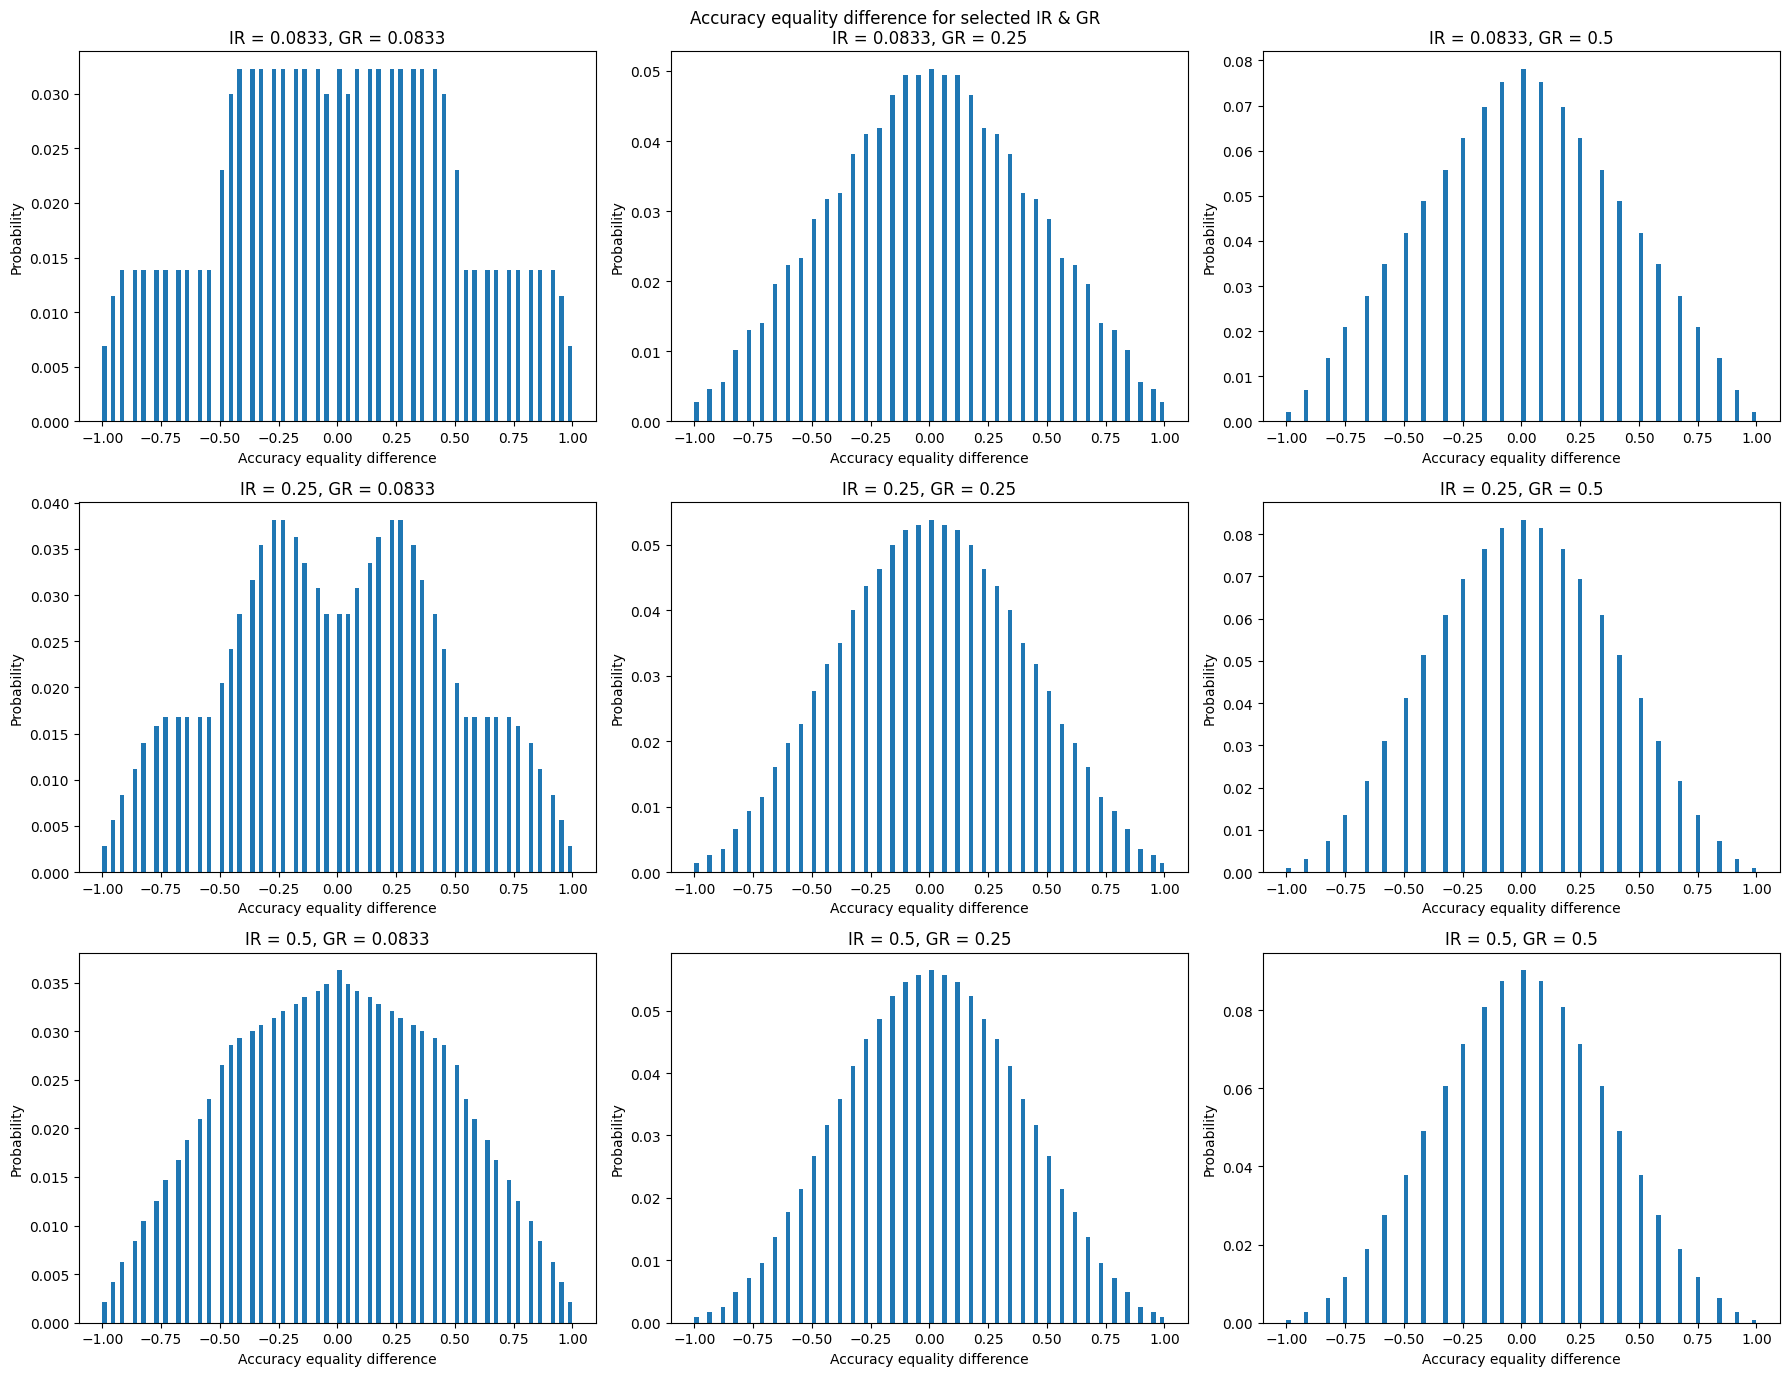

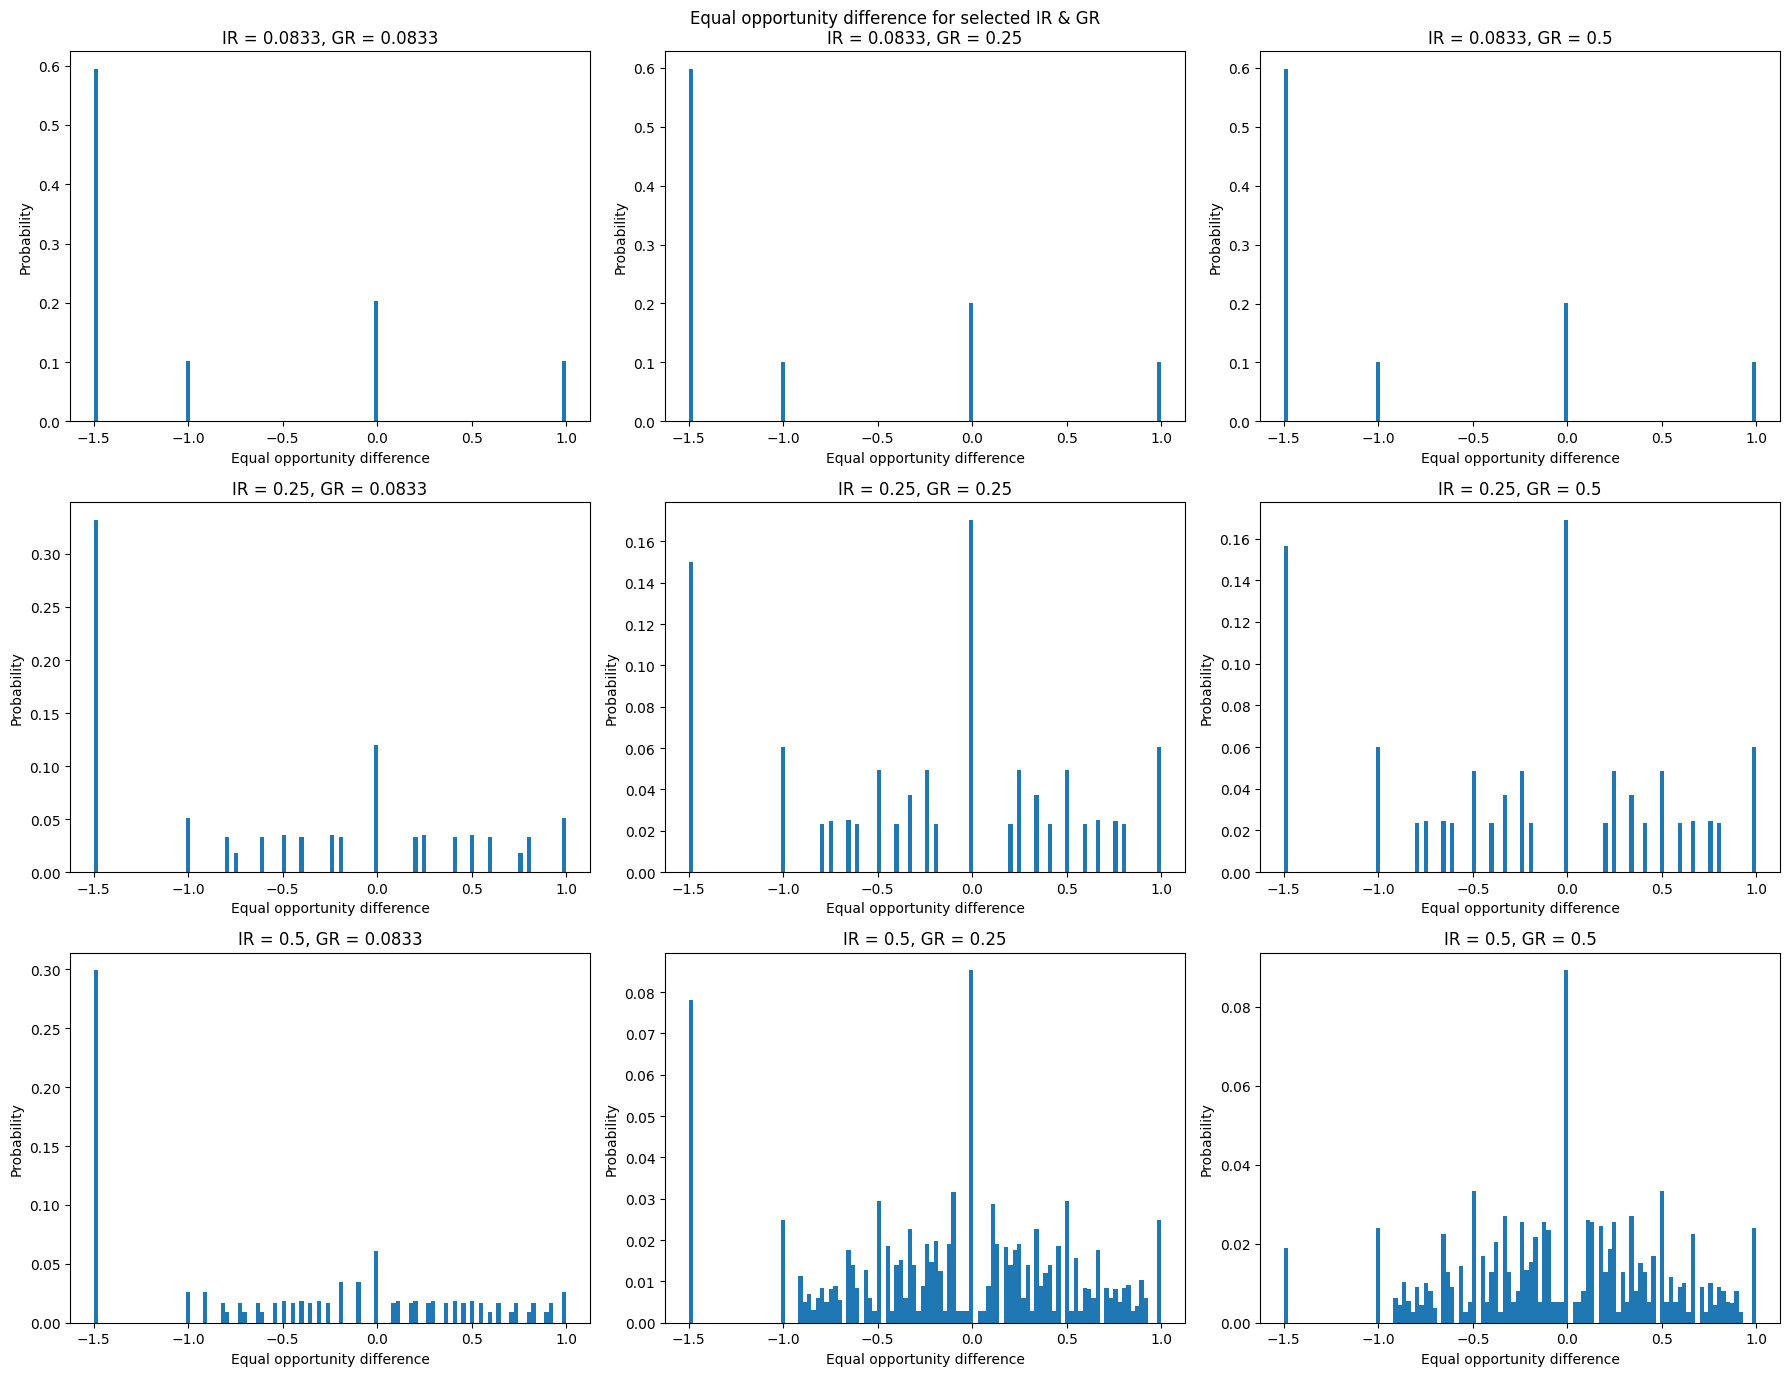

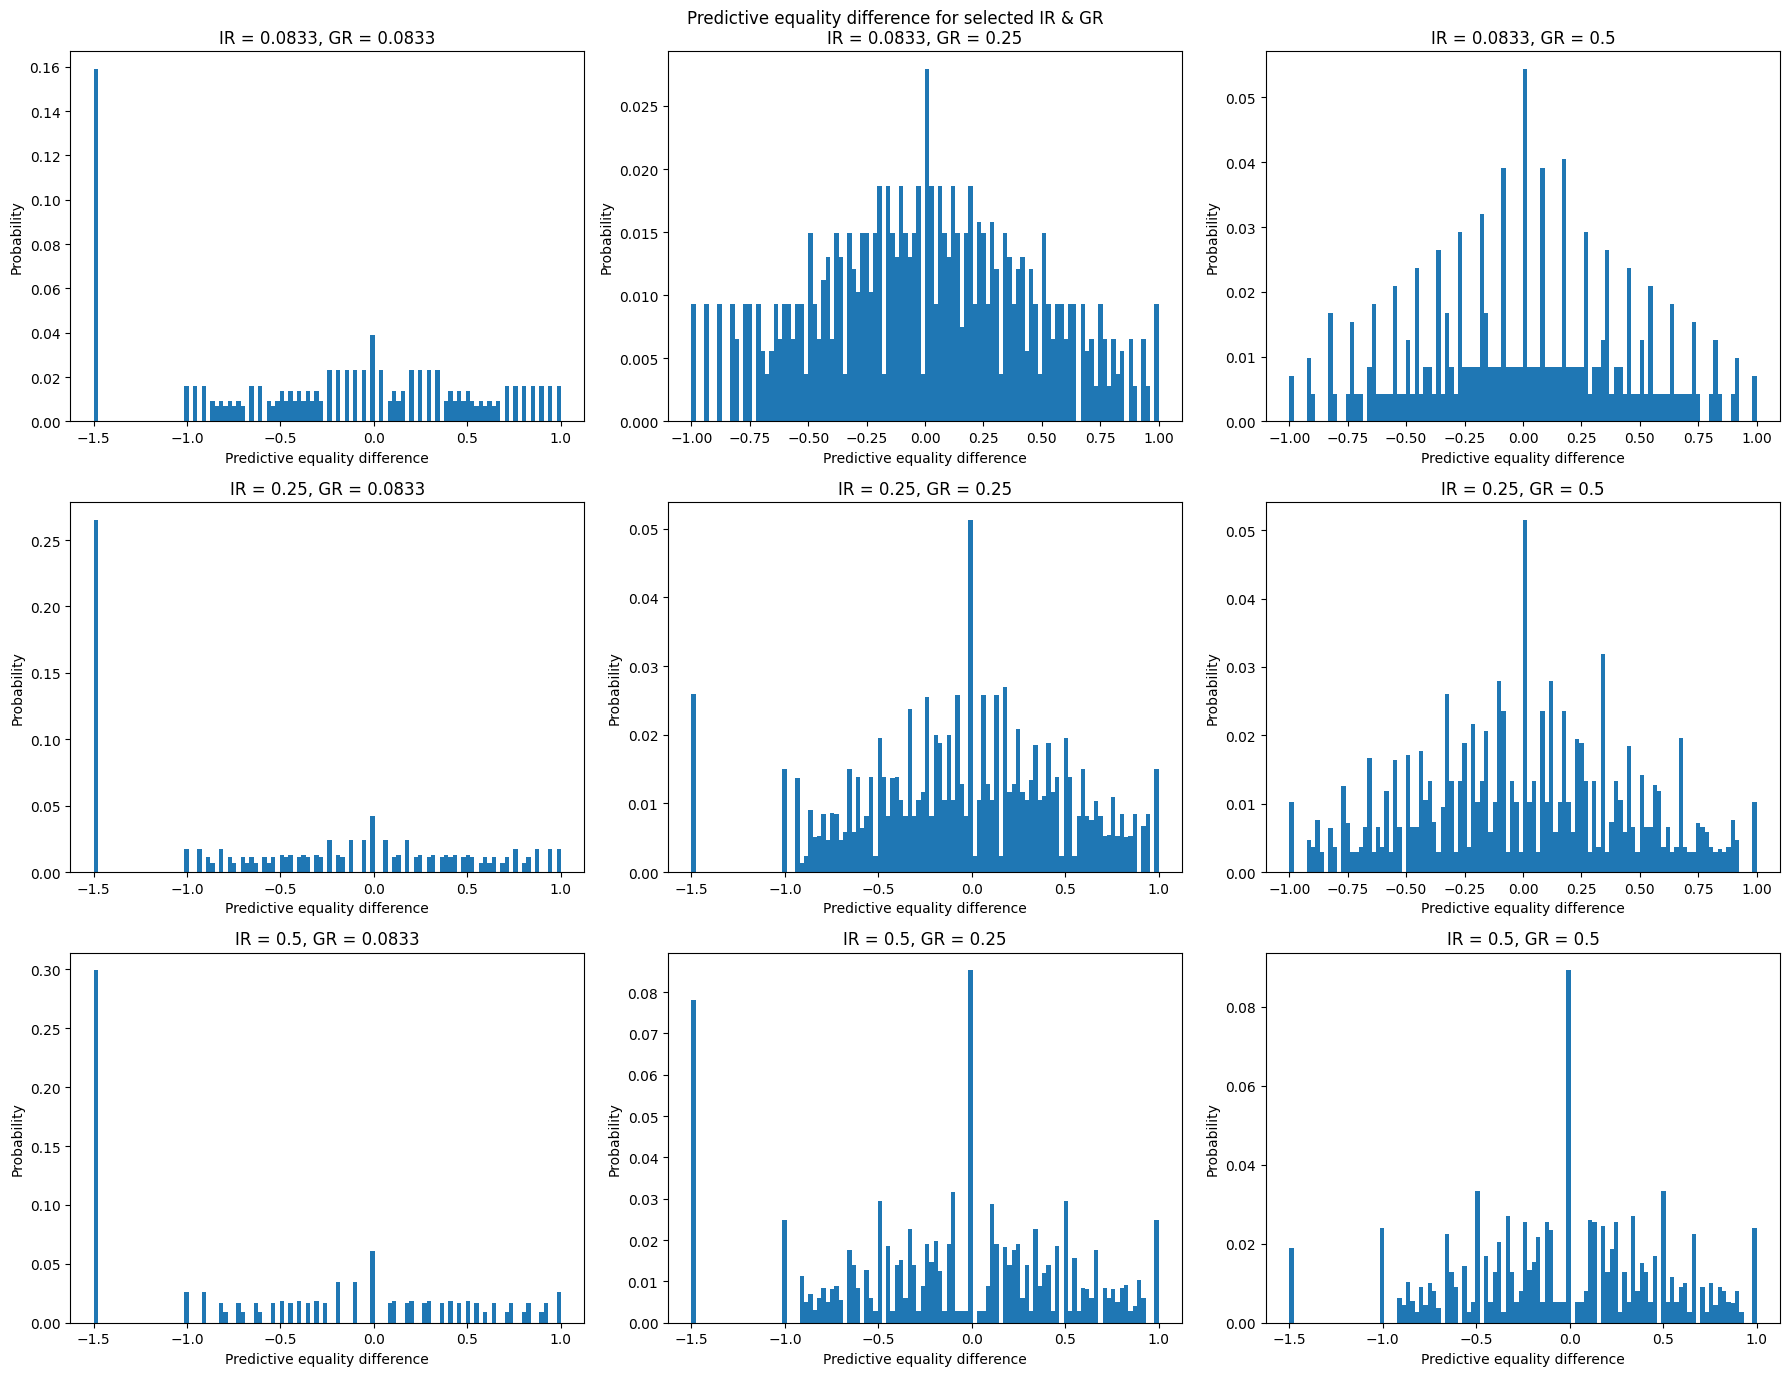

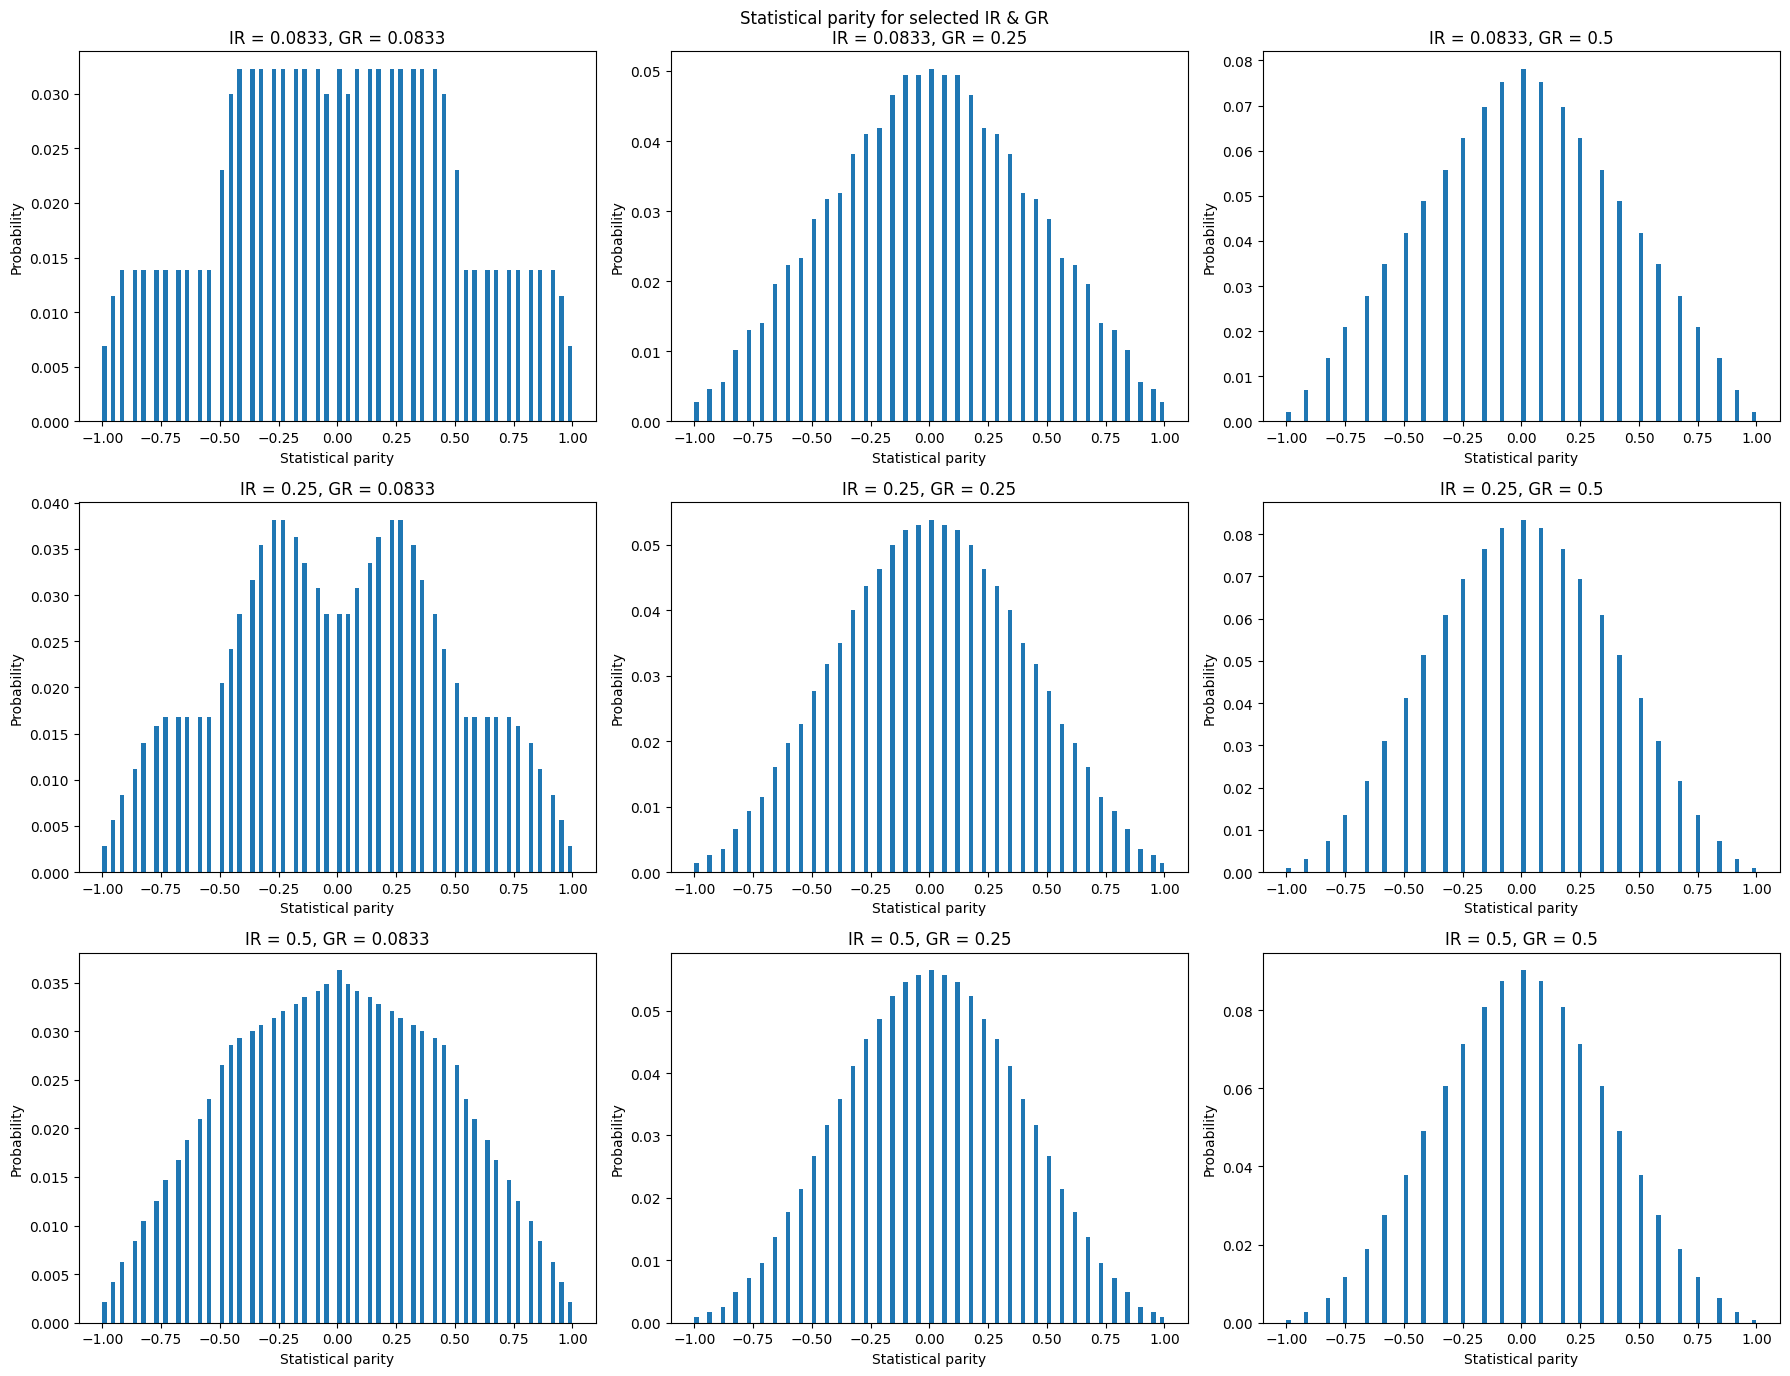

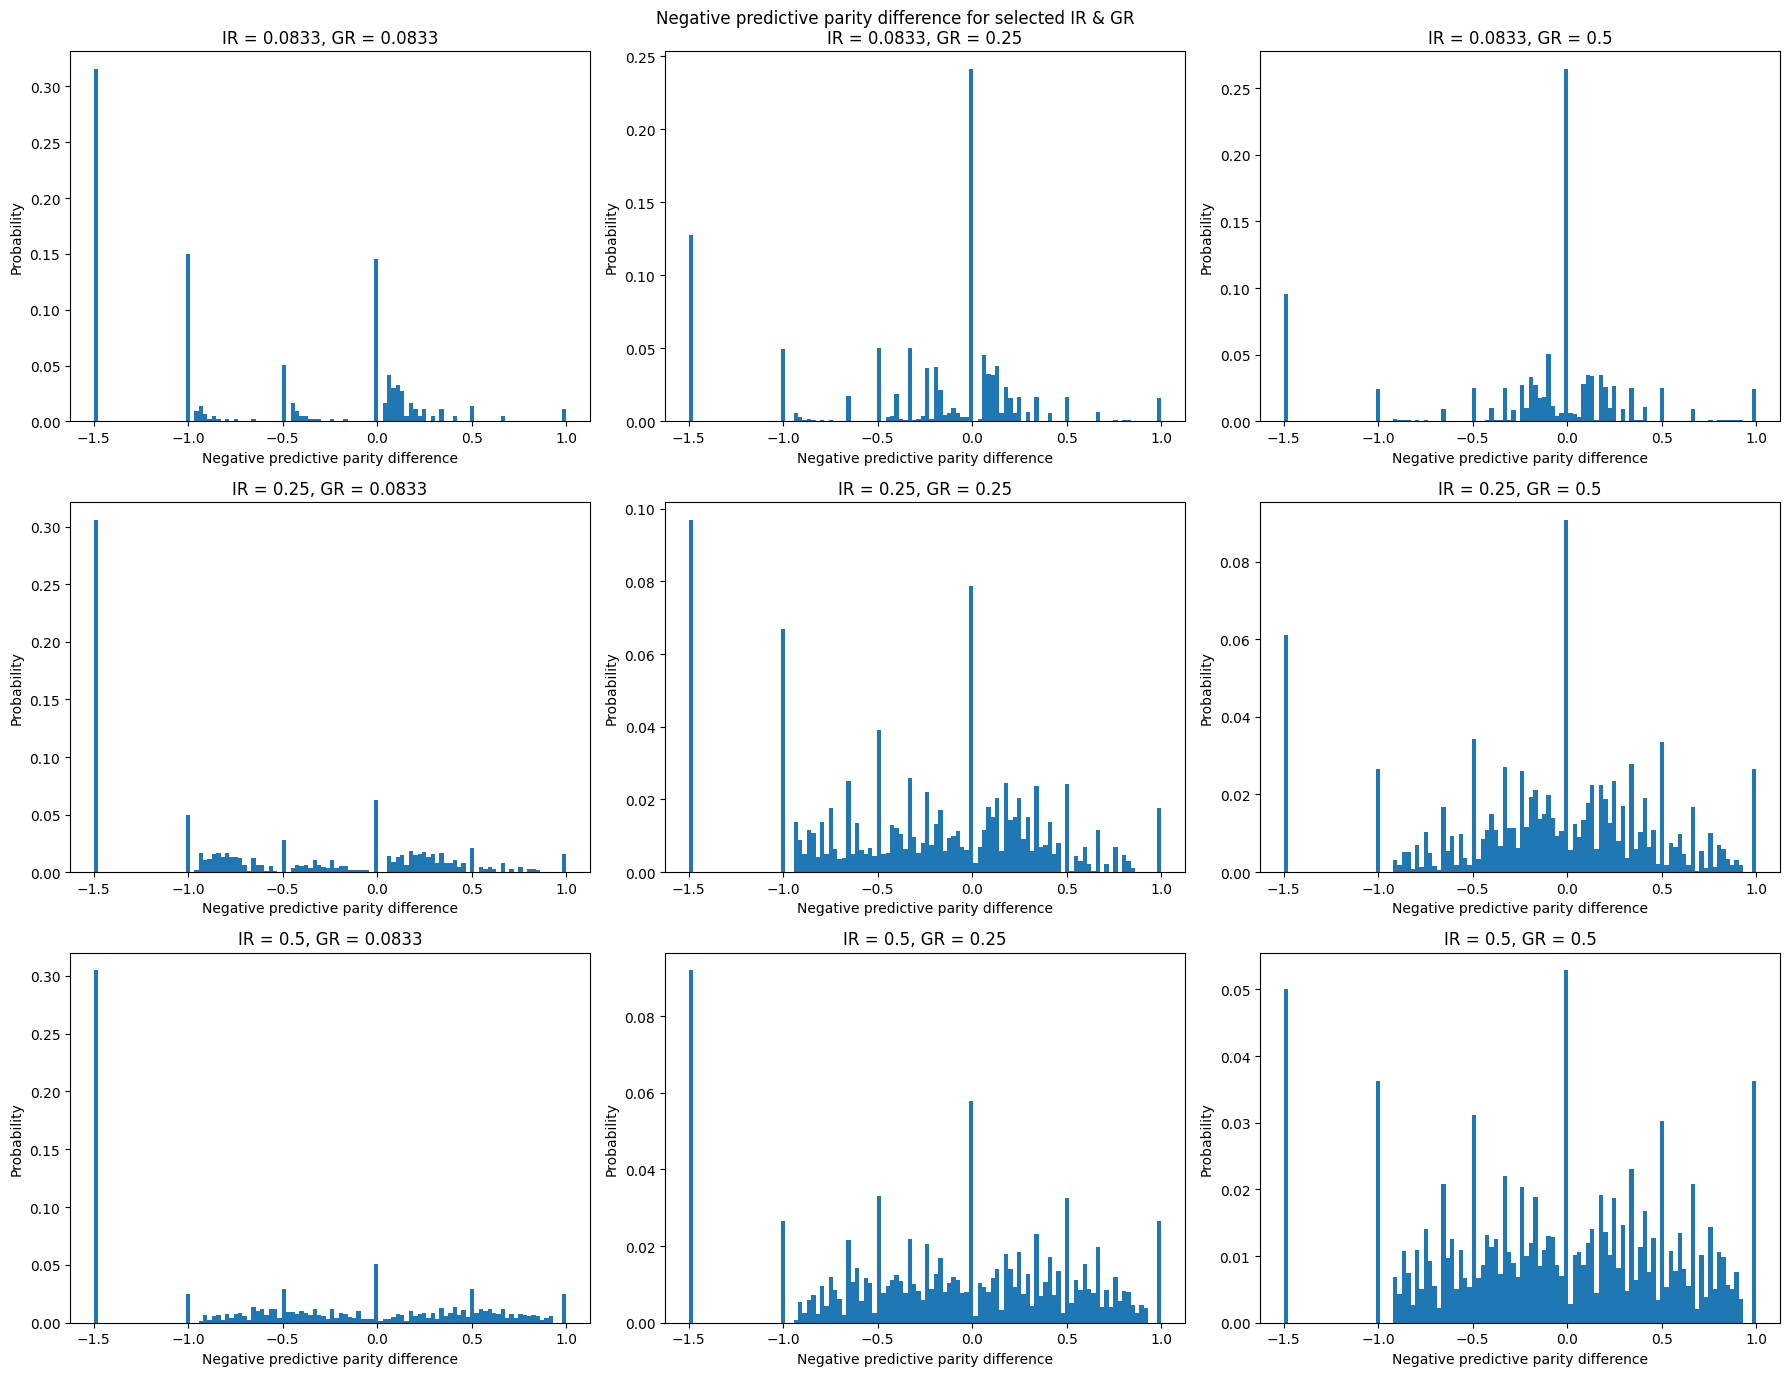

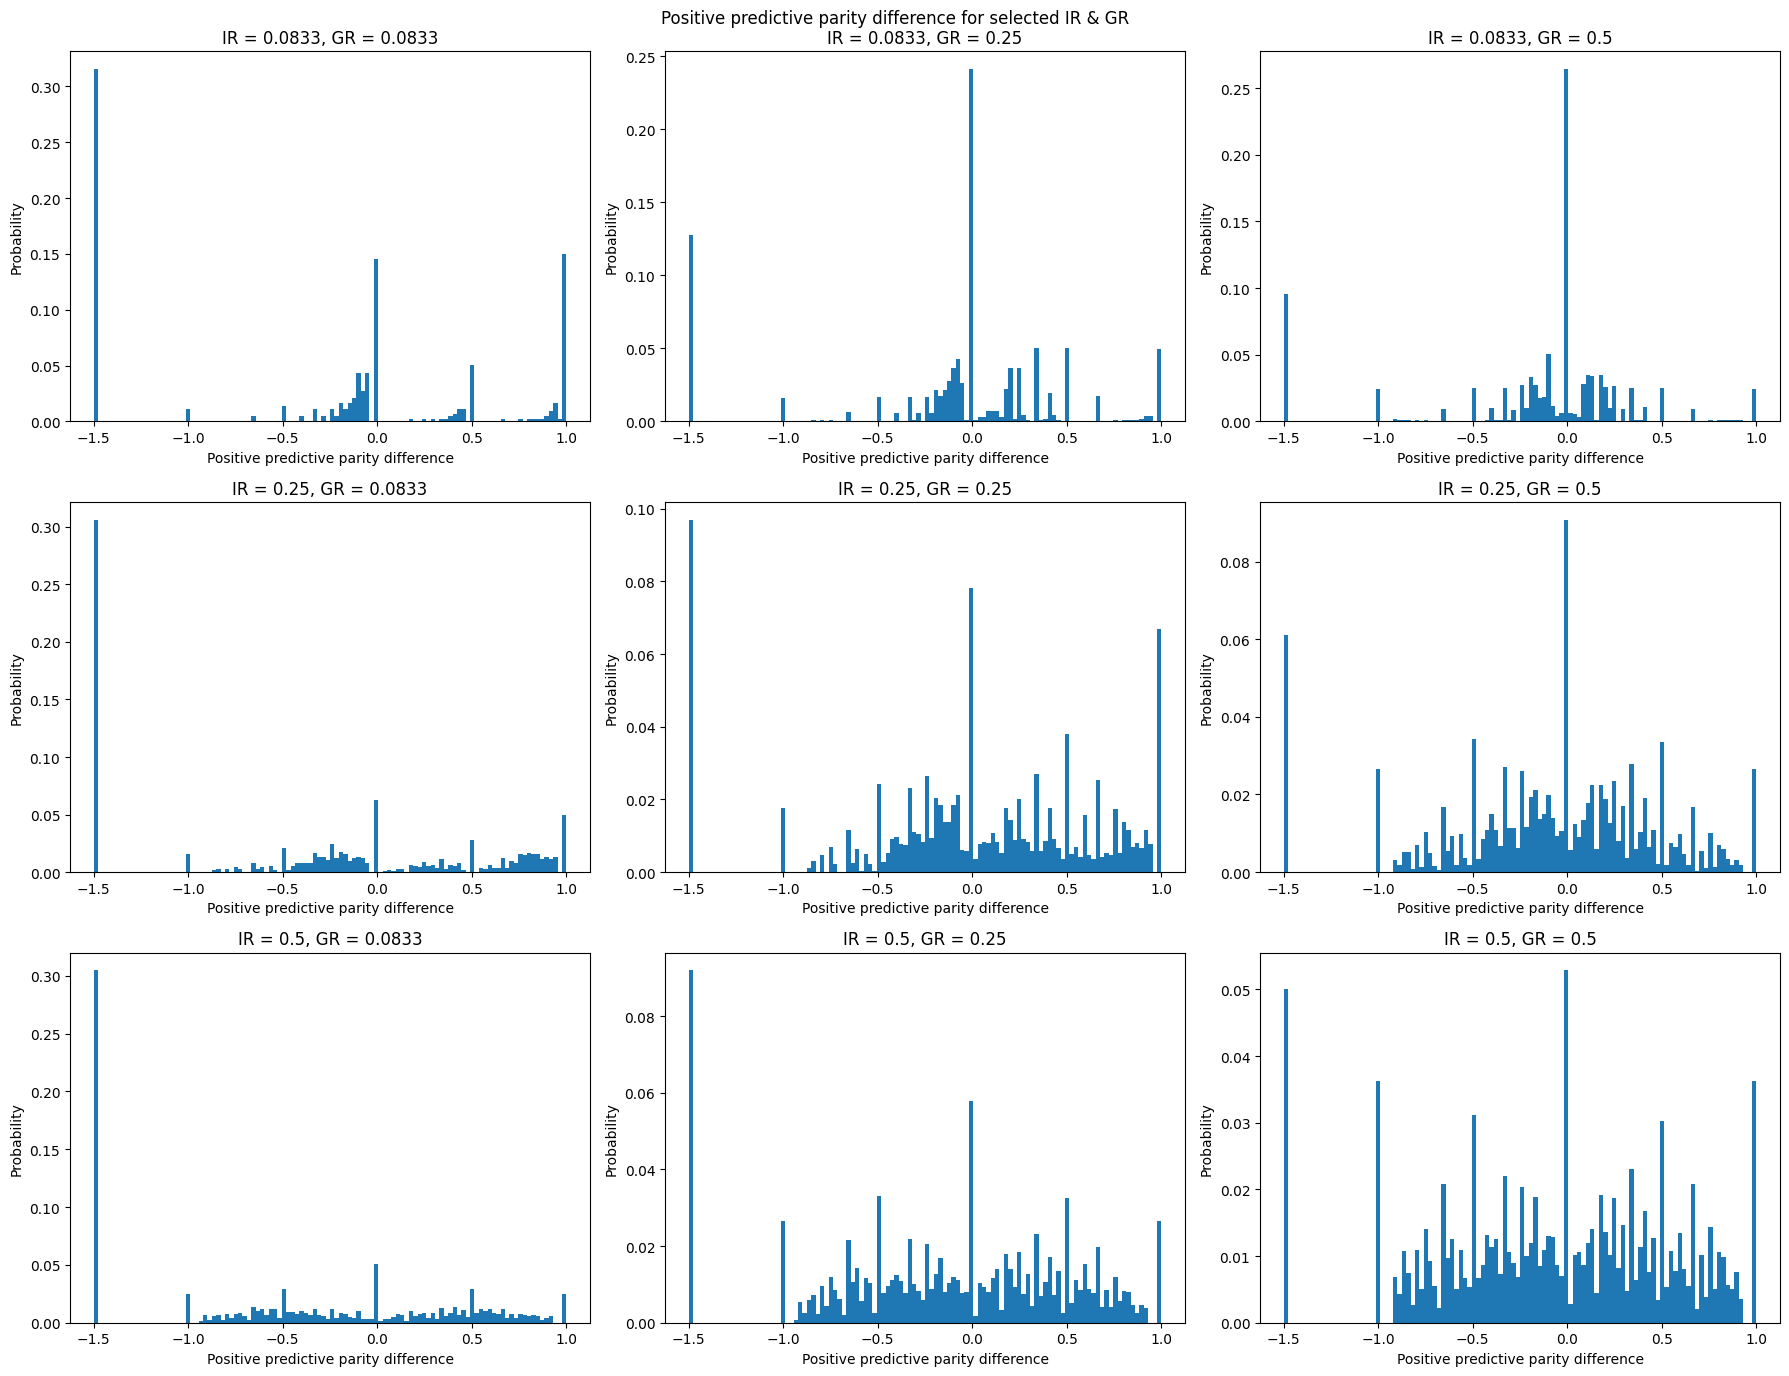

In [5]:
# don't need the symmetrical plots
gs = gr_selected[:len(gr_selected) // 2 + 1]
is_ = ir_selected[:len(ir_selected) // 2 + 1]

for metric_info in metrics.items():
    # for bins in [64, 72, 92, 108, 128]:
    bins = 108

    fig = plot_histograms_01(metric_info, gs, is_, bins)
    fig.savefig(path.join(plots_dir, f'MPL_norm_half_b{bins}_{metric_info[1]}.png'), dpi=300)
    plt.show()

## Sharing y-axis for NaNs and numbers

In [6]:
m_file, m_name= 'equal_opp_ratio.bin', 'Equal opportunity ratio'

with open(path.join(calculations_dir, m_file), 'rb') as f:
    metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

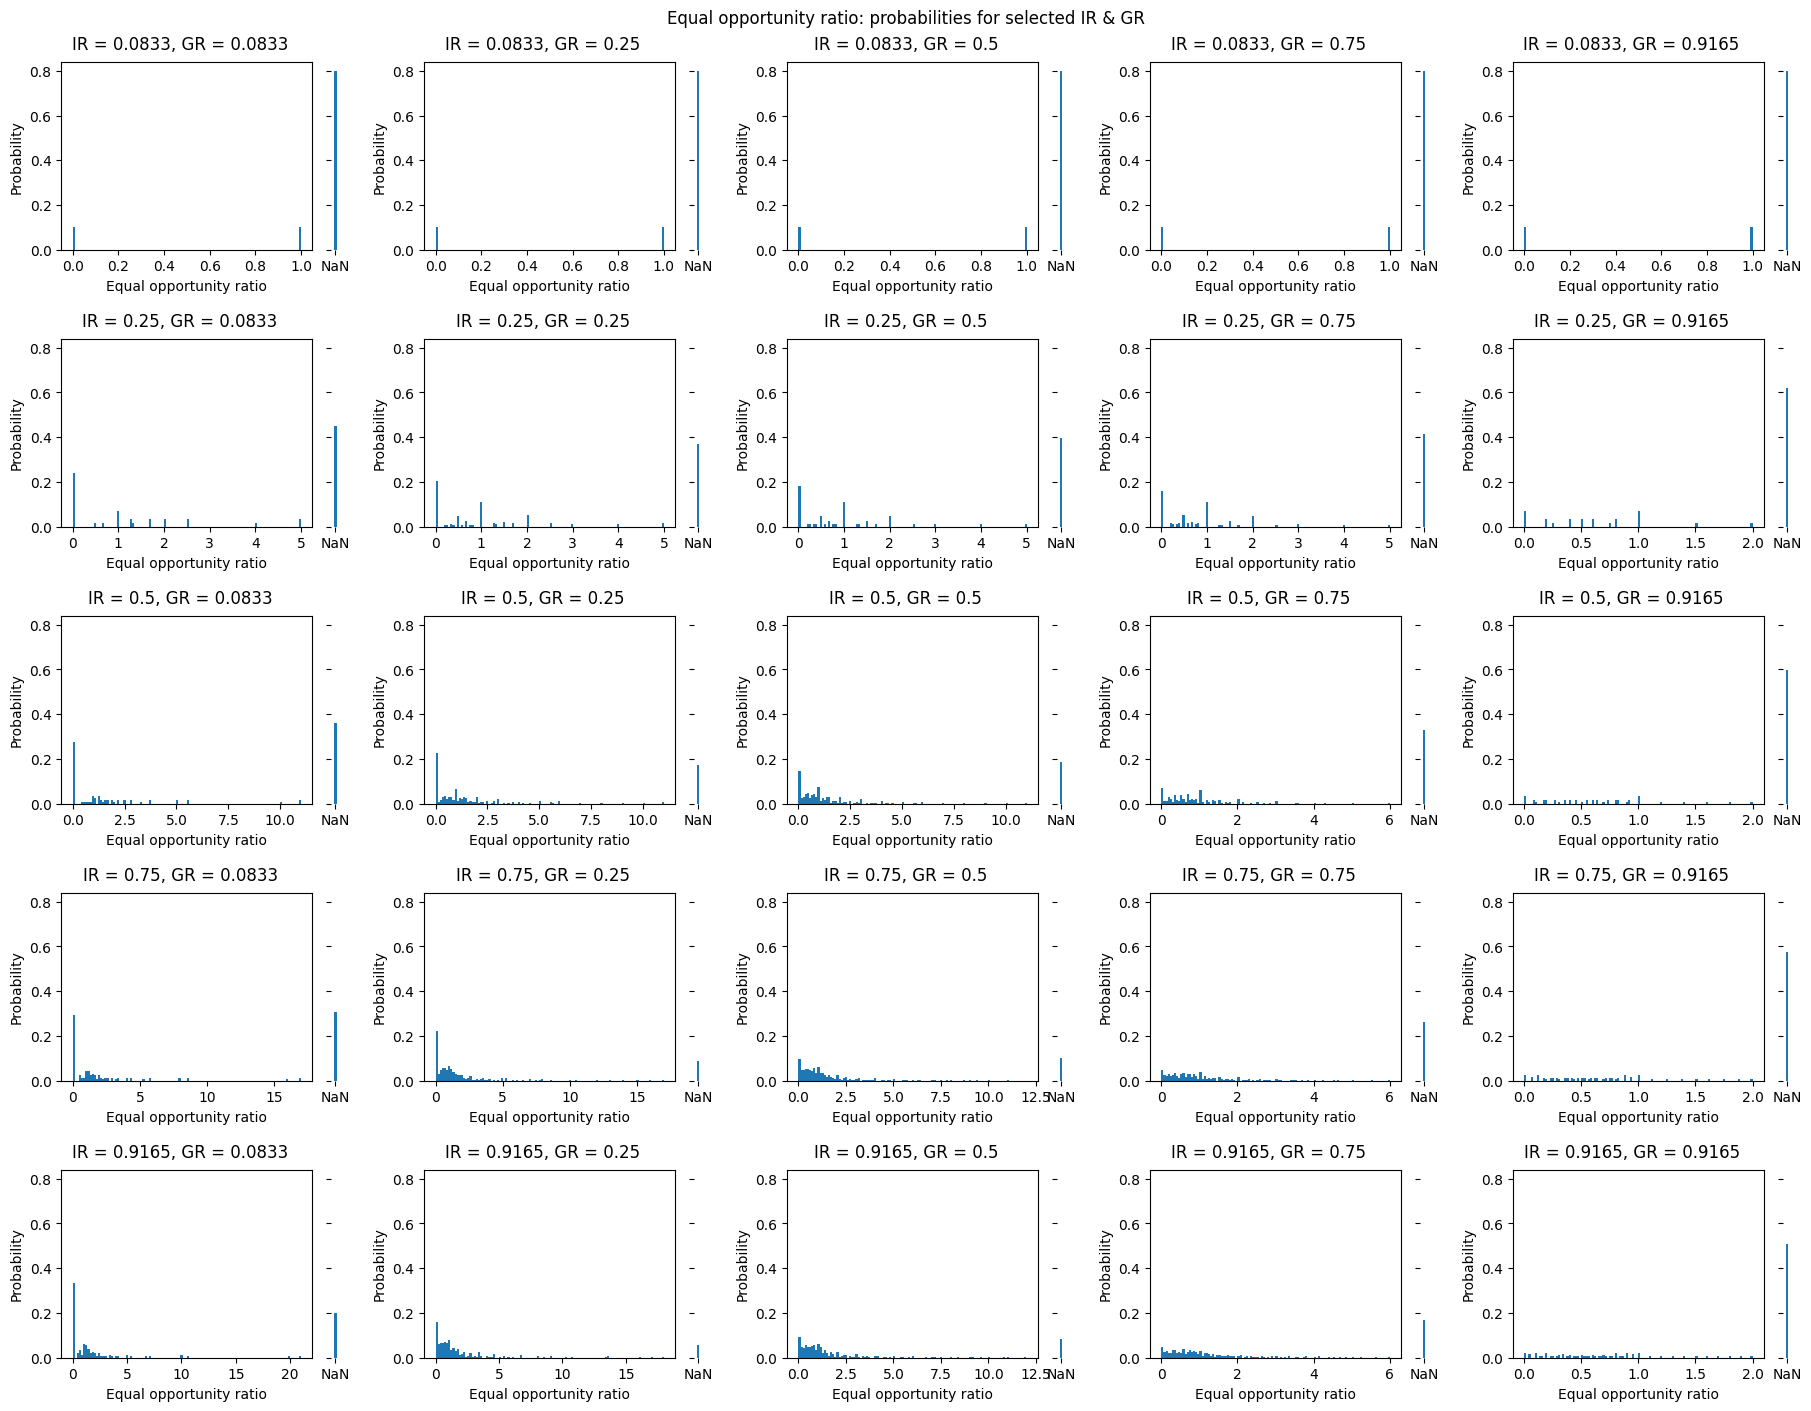

In [7]:
# Equal opportunity ratio
# with NaNs
# approach: subfigures

BINS = 108
ratios = [1./12, 1./4, 1./2, 3./4, 11./12]
grs = np.float16(ratios)
irs = np.float16(ratios)


# merge info about metric values and balance ratios
df = pd.concat([gr, ir, metric], axis=1)
# filter to get only results for selected ratios
df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
df = df.replace(np.inf, np.nan).replace(np.nan, -2)
df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

# fig, ax = plt.subplots(len(irs), len(grs), figsize=(18, 14))
fig = plt.figure(figsize=(18, 14), layout='constrained')      # layout='tight'
subfigs = fig.subfigures(len(irs), len(grs), wspace=0.04, hspace=0.04)    #
y_max = 0

for i, ir_val in enumerate(irs):
    for g, gr_val in enumerate(grs):
        # set up axes
        gs = subfigs[i, g].add_gridspec(1, 2, width_ratios=[30, 1], wspace=0)
        ax = gs.subplots(sharex=False, sharey=True)        # 1, 2, sharex=False, sharey=True, width_ratios=[1, 40]
        subfigs[i, g].suptitle(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')

        # separate nans and numbers
        df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
        total = df_tmp.shape[0]
        df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
        nan_prob = 0 if total == 0 else df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

        # prepare data for plotting
        binned, edges = np.histogram(df_not_nan[m_name], bins=BINS)
        binned = 0 if total == 0 else binned / total

        # plot not nans
        ax[0].hist(edges[:-1], edges, weights=binned)
        ax[0].set_xlabel(m_name)
        ax[0].set_ylabel('Probability')

        # plot nans and label the subfigure
        ax[1].bar(0, nan_prob)
        ax[1].set_xticks([0], ['NaN'])
        ax[1].set_xlim(-1.5, 1.5)
        ax[1].set_frame_on(False)

        # y-axis limits
        y_max = max(y_max, ax[0].get_ylim()[1])

# set sharey
for i, ir_val in enumerate(irs):
    for g, gr_val in enumerate(grs):
        subfigs[i, g].subplots_adjust(top=0.9)
        subfigs[i, g].set_facecolor('white')
        subfigs[i, g].axes[0].set_ylim(0, y_max)
        # subfigs[i, g].axes[1].set_ylim(0, y_max)


fig.suptitle(f'{m_name}: probabilities for selected IR & GR')
# fig.tight_layout()
fig.savefig(path.join(plots_dir, f'MPL_withnan_constrained_{m_name}.png'), dpi=300)
plt.show()

In [10]:
def plot_histograms_02(metric_info, grs, irs, bins_n):
    m_file, m_name= metric_info

    with open(path.join(calculations_dir, m_file), 'rb') as f:
        metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

    df = pd.concat([gr, ir, metric], axis=1)
    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
    df = df.replace(np.inf, np.nan).replace(np.nan, -2)
    df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

    fig = plt.figure(figsize=(18, 14), layout='constrained')
    subfigs = fig.subfigures(len(irs), len(grs), wspace=0.04, hspace=0.04)
    y_max = 0

    for i, ir_val in enumerate(irs):
        for g, gr_val in enumerate(grs):
            # set up axes
            gs = subfigs[i, g].add_gridspec(1, 2, width_ratios=[30, 1], wspace=0)
            ax = gs.subplots(sharex=False, sharey=True)
            subfigs[i, g].suptitle(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')

            # separate nans and numbers
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
            total = df_tmp.shape[0]
            if total != 0:
                df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
                nan_prob = df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

                # prepare data for plotting
                binned, edges = np.histogram(df_not_nan[m_name], bins=bins_n)
                binned = binned / total

                # plot not nans
                ax[0].hist(edges[:-1], edges, weights=binned, fc='black', ec='black')

                # plot nans - without drawing the axis frame
                ax[1].bar(0, nan_prob, fc='red', ec='red')

            ax[0].set_xlabel(m_name)
            ax[0].set_ylabel('Probability')
            ax[1].set_xticks([0], ['NaN'])
            ax[1].set_xlim(-1.5, 1.5)
            ax[1].tick_params(axis='x', which='both', length=0)
            ax[1].set_frame_on(False)

            # y-axis limits
            y_max = max(y_max, ax[0].get_ylim()[1])
            if i == 0 and g == 0:
                continue
            subfigs[0, 0].axes[0].sharey(ax[0])

    # set sharey
    subfigs[0, 0].axes[0].set_ylim(0, y_max)
    # for i, ir_val in enumerate(irs):
    #     for g, gr_val in enumerate(grs):
    #         # subfigs[i, g].subplots_adjust(top=0.9)
    #         # subfigs[i, g].set_facecolor('white')
    #         # subfigs[i, g].axes[0].set_ylim(0, y_max)
    #         # subfigs[i, g].axes[1].set_ylim(0, y_max)

    fig.suptitle(f'{m_name}: probabilities for selected IR & GR')

    del metric
    del df
    gc.collect()

    return fig

ValueError: y-axis is already shared

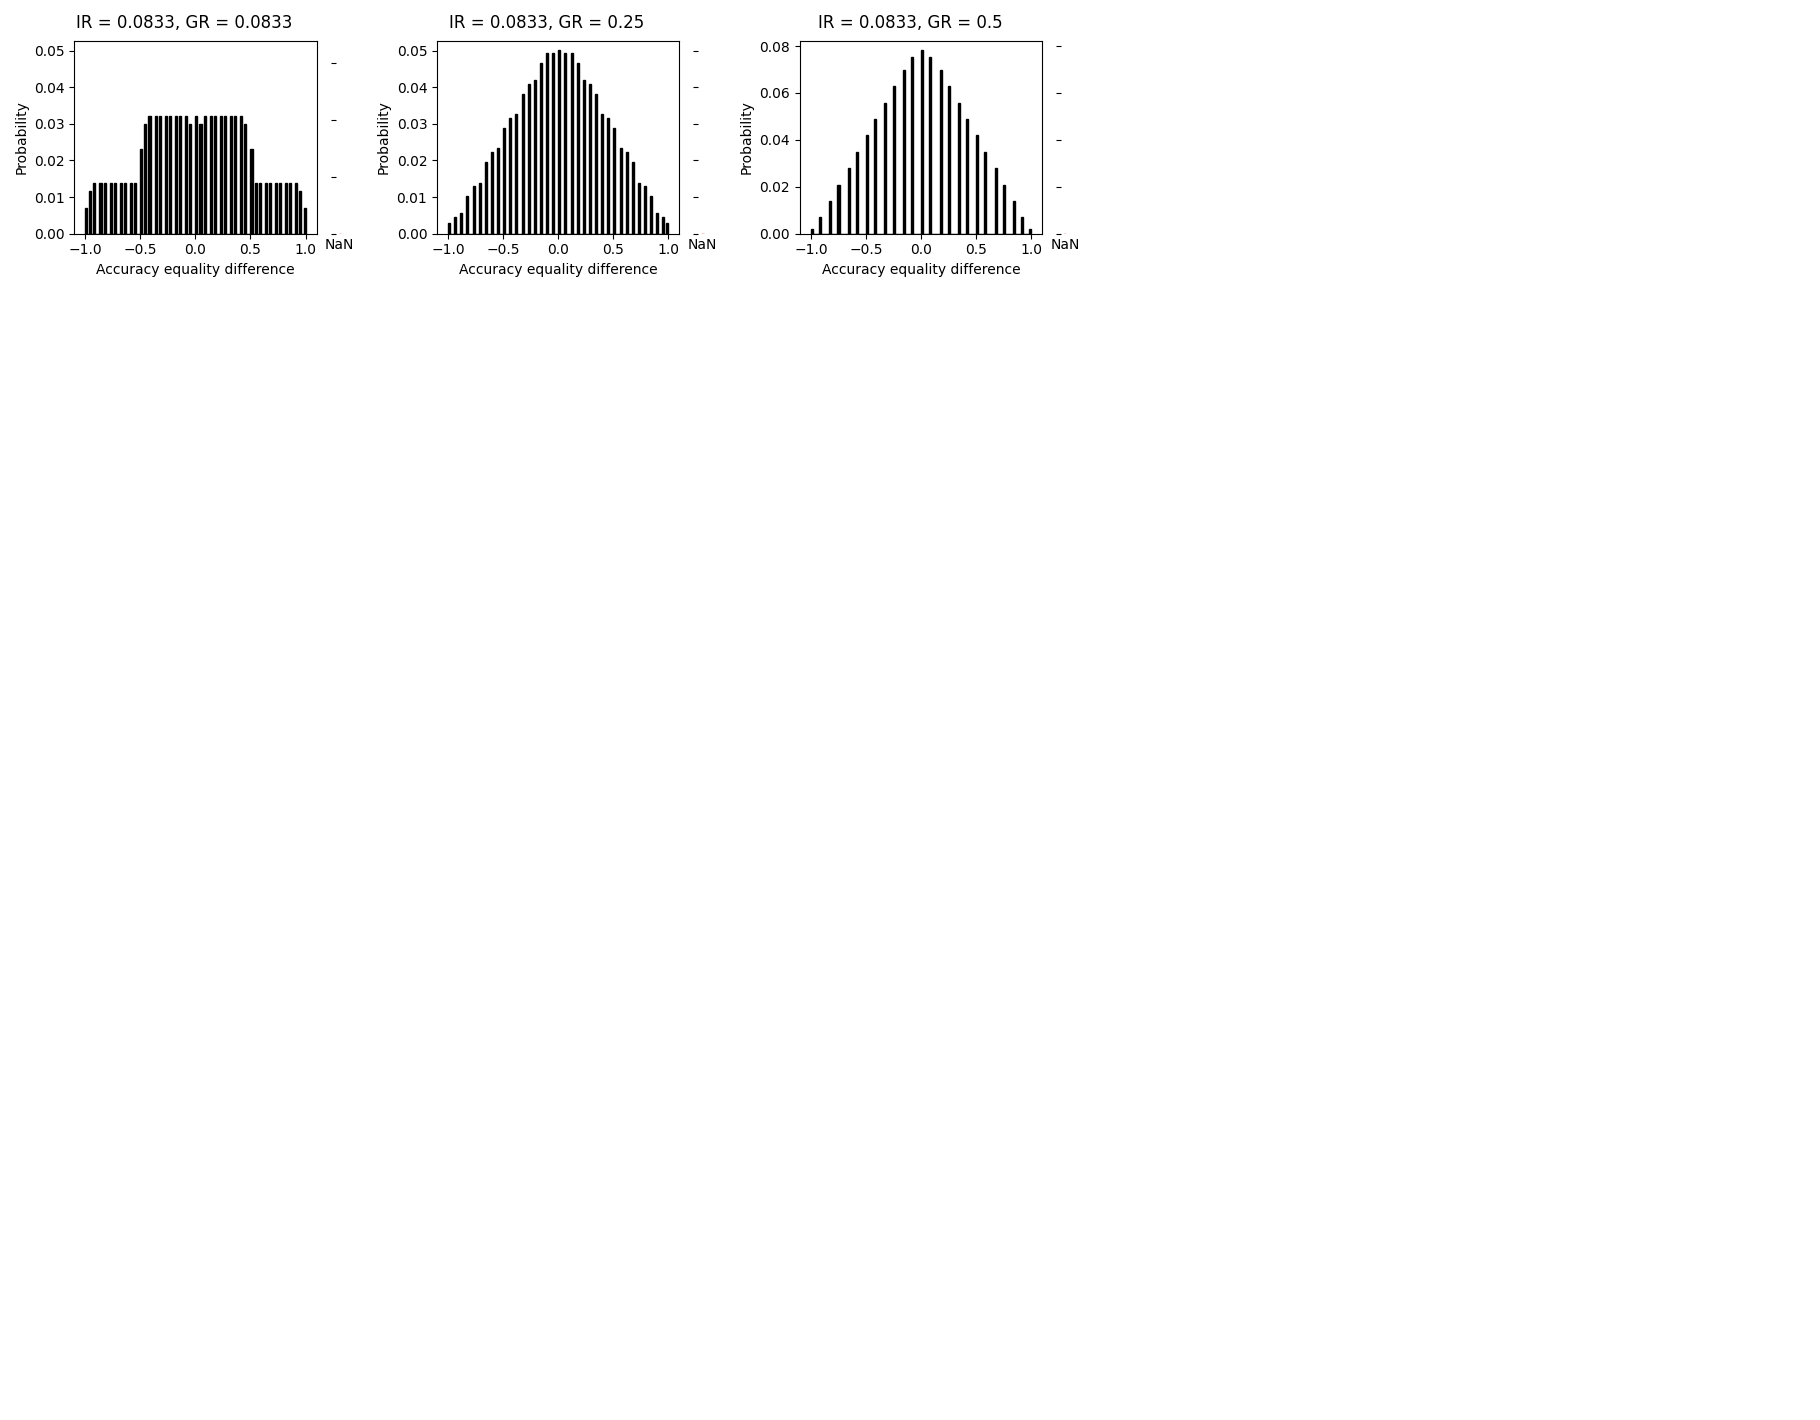

In [12]:
ratios = [1./12, 1./4, 1./2, 3./4, 11./12] if sample_size == 24 else [1./28, 1./4, 1./2, 3./4, 27./28]
grs = np.float16(ratios)
irs = np.float16(ratios)
BINS = 108

for metric_info in metrics.items():
    fig = plot_histograms_02(metric_info, grs, irs, BINS)
    fig.savefig(path.join(plots_dir, f'MPL_withnan_b{BINS}_{metric_info[1]}_sharey.png'), dpi=300)
    # plt.show()
    plt.close(fig)
    # break

### nans

Infs: 376740
Nans: 315315


TypeError: object of type 'int' has no len()

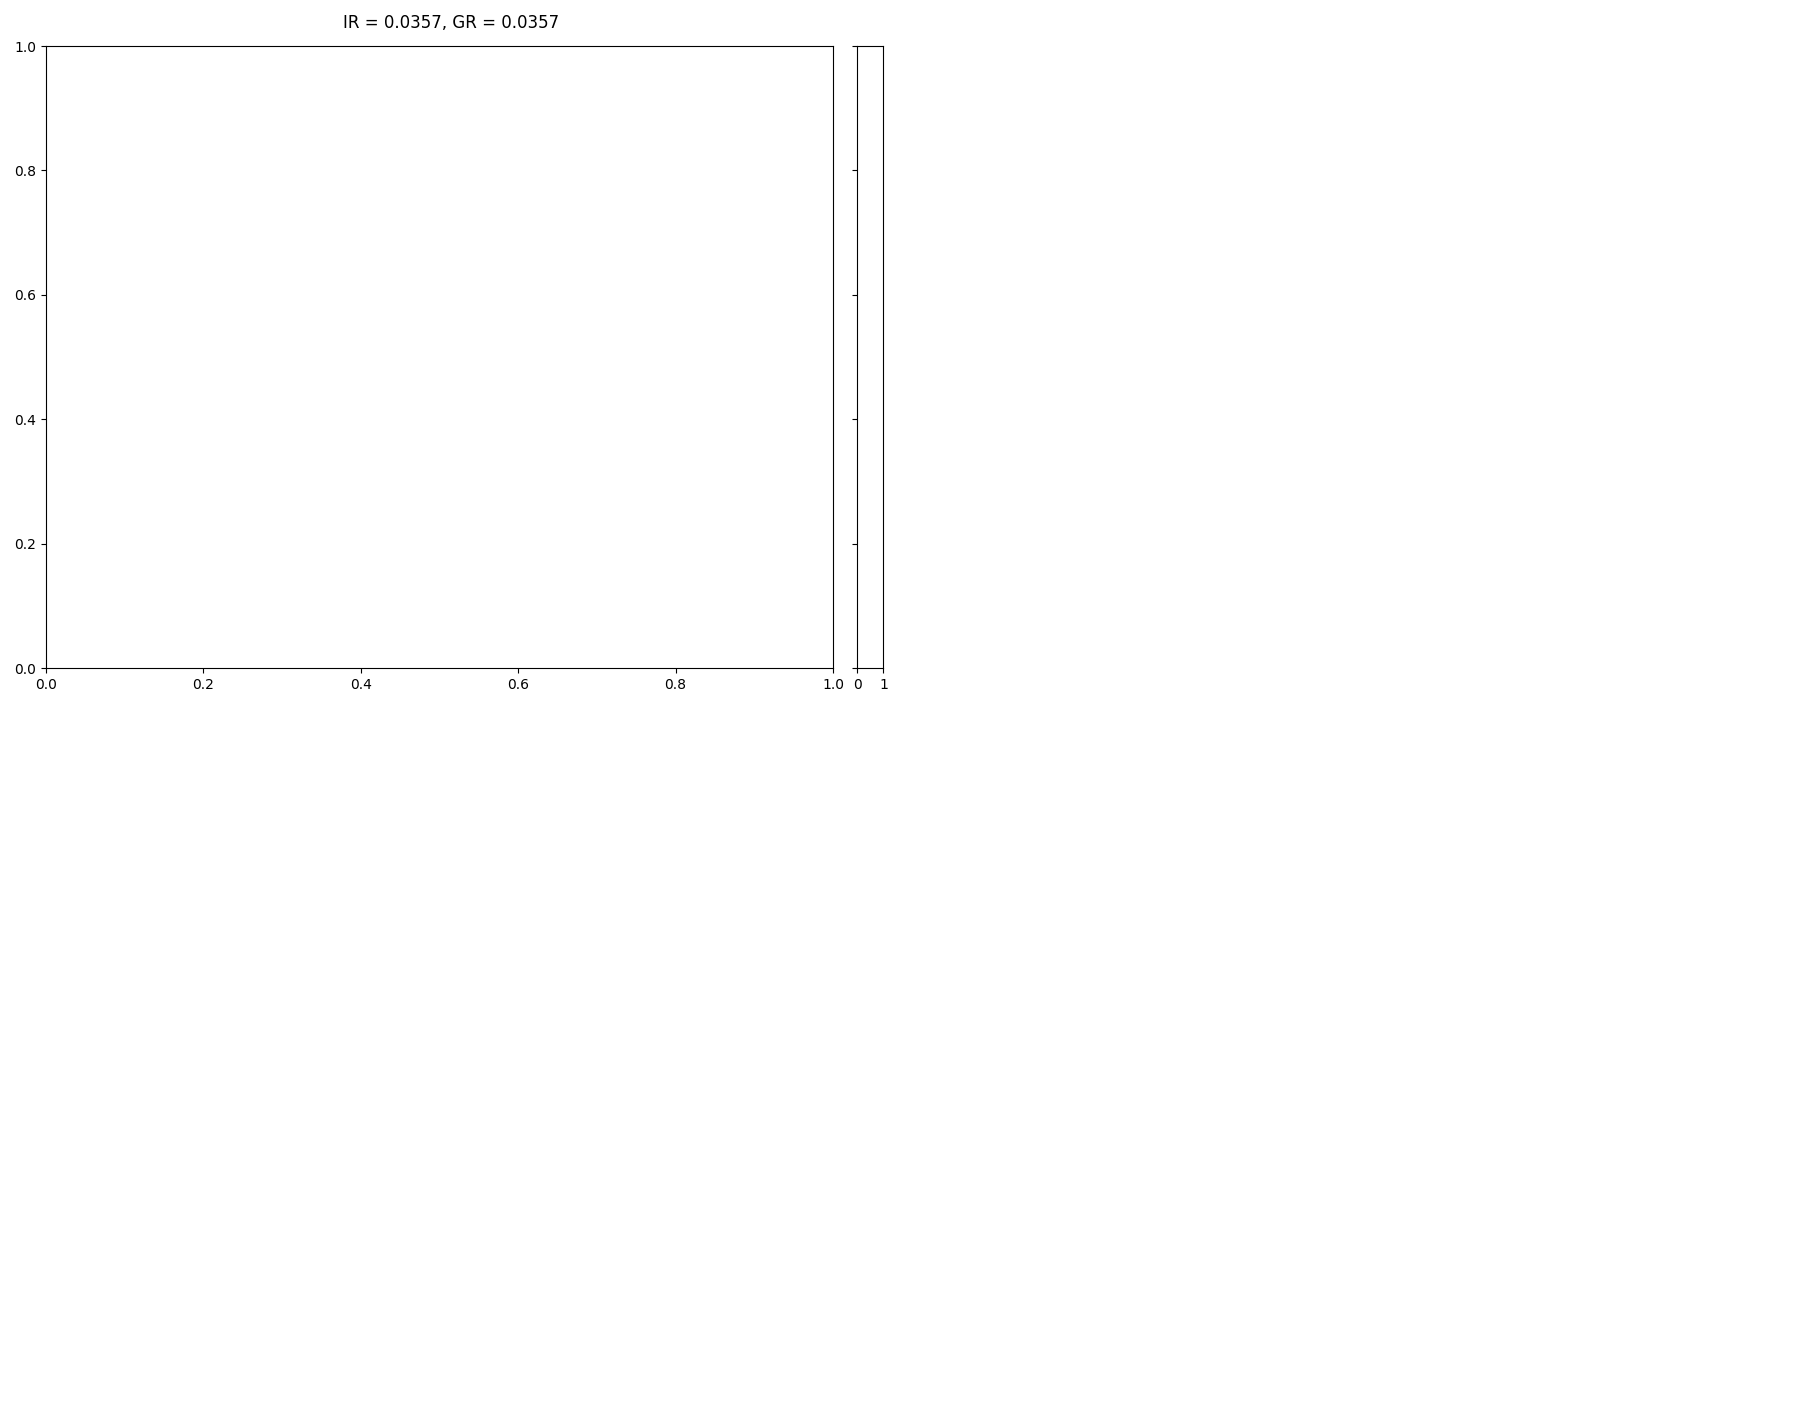

In [13]:
ratios = [1./28, 27./28] if sample_size == 24 else [1./12, 11./12]
grs = np.float16(ratios)
irs = np.float16(ratios)

# Equal opportunity ratio
# with NaNs
# approach: subfigures

BINS = 108

m_file, m_name= 'pos_pred_parity_ratio.bin', 'Positive predictive parity ratio'

with open(path.join(calculations_dir, m_file), 'rb') as f:
    metric = pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[m_name])

# merge info about metric values and balance ratios
df = pd.concat([gr, ir, metric], axis=1)

# count infs
print(f'Infs: {df.loc[df[m_name] == np.inf].shape[0]}')
# count nans
print(f'Nans: {df.loc[df[m_name].isna()].shape[0]}')

# filter to get only results for selected ratios
df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]
df = df.replace(np.inf, np.nan).replace(np.nan, -2)
df['typeVal'] = np.where(df[m_name] == -2, 'NaN', 'not NaN')

# fig, ax = plt.subplots(len(irs), len(grs), figsize=(18, 14))
fig = plt.figure(figsize=(18, 14), layout='constrained')      # layout='tight'
subfigs = fig.subfigures(len(irs), len(grs), wspace=0.04, hspace=0.04)    #

for i, ir_val in enumerate(irs):
    for g, gr_val in enumerate(grs):
        # set up axes
        gs = subfigs[i, g].add_gridspec(1, 2, width_ratios=[30, 1], wspace=0)
        ax = gs.subplots(sharex=False, sharey=True)        # 1, 2, sharex=False, sharey=True, width_ratios=[1, 40]
        subfigs[i, g].suptitle(f'IR = {round(float(ir_val), 4)}, GR = {round(float(gr_val), 4)}')

        # separate nans and numbers
        df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
        total = df_tmp.shape[0]
        df_not_nan = df_tmp.loc[df_tmp[m_name] != -2]
        nan_prob = 0 if total == 0 else df_tmp.loc[df_tmp[m_name] == -2].shape[0] / total

        # prepare data for plotting
        binned, edges = np.histogram(df_not_nan[m_name], bins=BINS)
        binned = 0 if total == 0 else binned / total

        # plot not nans
        ax[0].hist(edges[:-1], edges, weights=binned)
        ax[0].set_xlabel(m_name)
        ax[0].set_ylabel('Probability')

        # plot nans and label the subfigure
        ax[1].bar(0, nan_prob)
        ax[1].set_xticks([0], ['NaN'])
        ax[1].set_xlim(-1.5, 1.5)
        ax[1].set_frame_on(False)

fig.suptitle(f'{m_name}: probabilities for selected IR & GR')
# fig.tight_layout()
# fig.savefig(path.join(plots_dir, f'MPL_withnan_constrained_{m_name}.png'), dpi=300)
plt.show()
del metric
del df
gc.collect()

## Share y-axis scaling with subplot mosaic

In [14]:
from matplotlib.gridspec import GridSpec
from copy import deepcopy


def plot_histograms_03(metric_info, grs, irs, ratios_labels, bins_n):
    m_file, m_name= metric_info

    with open(path.join(calculations_dir, m_file), 'rb') as f:
        df = pd.concat([gr, ir, pd.DataFrame(np.fromfile(f).astype(np.float64), columns=[m_name])], axis=1)

    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]

    print(f'{m_name}: inf: {df.loc[np.isinf(df[m_name])].shape[0]}, nan: {df.loc[np.isnan(df[m_name])].shape[0]}')

    df = df.replace(np.inf, np.nan)     # .replace(np.nan, -2)
    # df['typeVal'] = np.where(np.isnan(df[m_name]), 'NaN', 'not NaN')

    # [['a00', 'a00n', 'a01', 'a01n',...], ...]
    mosaic = [
        [f'a{i}{g}{x}' for g in range(len(grs)) for x in ['', 'n']]
        for i in range(len(irs))
    ]

    fig, axs = plt.subplot_mosaic(mosaic,
                                  width_ratios=[50, 1]*len(grs),
                                  sharex=False, sharey=True,
                                  layout='constrained', figsize=(18, 14),
                                  gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    fig.suptitle(f'{m_name}: probabilities for selected IR & GR')

    for i, ir_val in enumerate(irs):
        for g, gr_val in enumerate(grs):

            # separate nans and numbers
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
            total = df_tmp.shape[0]

            df_not_nan = df_tmp.loc[np.logical_not(np.isnan(df_tmp[m_name]))]
            nan_prob = df_tmp.loc[np.isnan(df_tmp[m_name])].shape[0] / total

            # prepare data for plotting
            binned, edges = np.histogram(df_not_nan[m_name], bins=bins_n)
            binned = binned / total

            # plot not nans
            axs[f'a{i}{g}'].hist(edges[:-1], edges, weights=binned, fc='black', ec='black')
            axs[f'a{i}{g}'].spines[['top', 'right']].set_visible(False)

            # plot nans - without drawing the axis frame
            axs[f'a{i}{g}n'].bar(0, nan_prob, fc='red', ec='red', width=0.1, lw=0)
            axs[f'a{i}{g}n'].spines[['top', 'left']].set_visible(False)

            # styling
            # x-axis labels
            if g == 0:
                axs[f'a{i}{g}'].set_ylabel(f'IR = {ratios_labels[i]}')

            # x-axis labels
            if i == 0:
                axs[f'a{i}{g}'].set_title(f'GR = {ratios_labels[g]}')
            if i == len(irs) - 1:   # last row
                axs[f'a{i}{g}n'].set_xticks([0], ['NaN'])
            else:
                axs[f'a{i}{g}'].set_xticklabels([])
                axs[f'a{i}{g}n'].set_xticks([0], [''])

    # del metric
    del df
    gc.collect()

    return fig

In [17]:
ratios = [1./28, 1./4, 1./2, 3./4, 27./28] if sample_size == 56 else [1./12, 1./4, 1./2, 3./4, 11./12]
ratios_labels = ['1/28', '1/4', '1/2', '3/4', '27/28'] if sample_size == 56 else ['1/12', '1/4', '1/2', '3/4', '11/12']

grs = np.float16(ratios)
irs = np.float16(ratios)
# grs, irs = ratios, ratios

BINS = 168

for metric_info in metrics.items():
# for metric_info in {'equal_opp_diff.bin': 'Equal opportunity difference'}.items():
    fig = plot_histograms_03(metric_info, grs, irs, ratios_labels, BINS)
    fig.savefig(path.join(plots_dir, f'histogram_b{BINS}_{metric_info[1]}_sharey.png'), dpi=300)
    # plt.show()
    plt.close(fig)

Accuracy equality difference: inf: 0, nan: 0
Equal opportunity difference: inf: 0, nan: 9630
Predictive equality difference: inf: 0, nan: 9630
Statistical parity: inf: 0, nan: 0
Negative predictive parity difference: inf: 0, nan: 8937
Positive predictive parity difference: inf: 0, nan: 8937


In [ ]:
def plot_histograms_no_nan(metric_info, grs, irs, ratios_labels, bins_n):
    m_file, m_name= metric_info

    with open(path.join(calculations_dir, m_file), 'rb') as f:
        df = pd.concat([gr, ir, pd.DataFrame(np.fromfile(f).astype(np.float64), columns=[m_name])], axis=1)

    # filter to get only results for selected ratios
    df = df.loc[df.ir.isin(irs) & df.gr.isin(grs)]

    print(f'{m_name}: inf: {df.loc[np.isinf(df[m_name])].shape[0]}, nan: {df.loc[np.isnan(df[m_name])].shape[0]}')

    df = df.replace(np.inf, np.nan)     # .replace(np.nan, -2)

    fig, axs = plt.subplots(len(irs), len(grs),
                            sharey=True, sharex=True,
                            layout='constrained', figsize=(18, 14),
                            gridspec_kw={'wspace': 0.1,
                                         'hspace': 0.1})

    fig.suptitle(f'{m_name}: probabilities for selected IR & GR')

    # wspace=0.04, hspace=0.04

    for i, ir_val in enumerate(irs):
        for g, gr_val in enumerate(grs):

            # separate nans and numbers
            df_tmp = df.loc[(df.ir == ir_val) & (df.gr == gr_val)]
            total = df_tmp.shape[0]

            df_not_nan = df_tmp.loc[np.logical_not(np.isnan(df_tmp[m_name]))]
            # nan_prob = df_tmp.loc[np.isnan(df_tmp[m_name])].shape[0] / total

            # prepare data for plotting
            binned, edges = np.histogram(df_not_nan[m_name], bins=bins_n)
            binned = binned / total

            # plot not nans
            axs[i, g].hist(edges[:-1], edges, weights=binned, fc='black', ec='black')
            # axs[i, g].spines[['top', 'right']].set_visible(False)

            # plot nans - without drawing the axis frame
            # axs[f'a{i}{g}n'].bar(0, nan_prob, fc='red', ec='red', width=0.1, lw=0)
            # axs[f'a{i}{g}n'].spines[['top', 'left']].set_visible(False)

            # styling
            # x-axis labels
            if g == 0:
                axs[i, g].set_ylabel(f'IR = {ratios_labels[i]}')

            # x-axis labels
            if i == 0:
                axs[i, g].set_title(f'GR = {ratios_labels[g]}')
            else:
                axs[i, g].set_xticklabels([])

    # del metric
    del df
    gc.collect()

    return fig

In [ ]:
for metric_info in metrics.items():
    fig = plot_histograms_no_nan(metric_info, grs, irs, ratios_labels, BINS)
    fig.savefig(path.join(plots_dir, f'histogram_b{BINS}_{metric_info[1]}_no_nan.png'), dpi=300)
    # plt.show()
    plt.close(fig)

### histograms properties

In [12]:
def get_properties_01(metric_info, ratio_b, ratio_imb):
    m_file, m_name= metric_info
    print(f'\n\n===\n{m_name}:')

    with open(path.join(calculations_dir, m_file), 'rb') as f:
        df = pd.concat([gr, ir, pd.DataFrame(np.fromfile(f).astype(np.float64), columns=[m_name])], axis=1)

    df_b = df.loc[(df.ir == ratio_b) & (df.gr == ratio_b)]
    df_imb = df.loc[(df.ir == ratio_imb) & (df.gr == ratio_imb)]
    del df
    # print(f'{m_name}: inf: {df.loc[np.isinf(df[m_name])].shape[0]}, nan: {df.loc[np.isnan(df[m_name])].shape[0]}')

    for df, ratio in [(df_b, ratio_b), (df_imb, ratio_imb)]:
        print(f' --> {ratio} <--')
        print(f'inf: {df.loc[np.isinf(df[m_name])].shape[0] / df.shape[0]}, nan: {df.loc[np.isnan(df[m_name])].shape[0] / df.shape[0]}')
        print(f'PPF: {df[df[m_name] == 0].shape[0] / df.shape[0]}')
        mode = df[m_name].mode()[0]
        print(f'Mode: {mode}\tprob: {df[df[m_name] == mode].shape[0] / df.shape[0]}')
        print(f'Unique vals: {df[m_name].nunique()}')

In [13]:
for metric_info in metrics.items():
    get_properties_01(metric_info, np.float16(1/2), np.float16(1/28))



===
Accuracy equality difference:
 --> 0.5 <--
inf: 0.0, nan: 0.0
PPF: 0.04175931081396397
Mode: 0.0	prob: 0.04175931081396397
Unique vals: 157
 --> 0.03570556640625 <--
inf: 0.0, nan: 0.0
PPF: 0.01303538175046555
Mode: -0.4444444444444444	prob: 0.01303538175046555
Unique vals: 136


===
Equal opportunity difference:
 --> 0.5 <--
inf: 0.0, nan: 0.0020765457735133007
PPF: 0.02225064475388241
Mode: 0.0	prob: 0.02225064475388241
Unique vals: 2007
 --> 0.03570556640625 <--
inf: 0.0, nan: 0.5977653631284916
PPF: 0.2011173184357542
Mode: 0.0	prob: 0.2011173184357542
Unique vals: 3


===
Predictive equality difference:
 --> 0.5 <--
inf: 0.0, nan: 0.0020765457735133007
PPF: 0.02225064475388241
Mode: 0.0	prob: 0.02225064475388241
Unique vals: 2007
 --> 0.03570556640625 <--
inf: 0.0, nan: 0.15363128491620112
PPF: 0.015828677839851025
Mode: 0.0	prob: 0.015828677839851025
Unique vals: 236


===
Statistical parity:
 --> 0.5 <--
inf: 0.0, nan: 0.0
PPF: 0.04175931081396397
Mode: 0.0	prob: 0.0417593

In [4]:
def get_properties_selected(df, metric_info, gr, ir):
    m_file, m_name= metric_info
    print(f' --> IR: {ir}, GR: {gr} <--')

    if gr:
        cond_gr = df['gr'] == gr
    else:
        cond_gr = True
    if ir:
        cond_ir = df['ir'] == ir
    else:
        cond_ir = True

    if (cond_ir is not True) or (cond_gr is not True):
        df = df.loc[cond_gr & cond_ir]
    # print(f'{m_name}: inf: {df.loc[np.isinf(df[m_name])].shape[0]}, nan: {df.loc[np.isnan(df[m_name])].shape[0]}')

    # for df, ratio in [(df_b, ratio_b), (df_imb, ratio_imb)]:
    # print(f' --> {ratio} <--')

    print(f'nan: {df.loc[np.isnan(df[m_name])].shape[0] / df.shape[0] * 100}%, inf: {df.loc[np.isinf(df[m_name])].shape[0] / df.shape[0] * 100}%')
    print(f'PPF: {df[df[m_name] == 0].shape[0] / df.shape[0] * 100}%')
    # mode = df[m_name].mode()[0]
    # print(f'Mode: {mode}\tprob: {df[df[m_name] == mode].shape[0] / df.shape[0]}')
    print(f'Unique vals: {df[m_name].nunique()}')

    # # TODO: Wasserstein distance
    # gr_d, ir_d = gr, ir
    # if gr_d != .5:
    #     gr_d = 0.5
    #     # TODO
    #
    # gr_d = gr
    # if ir_d != .5:
    #     ir_d = 0.5
    #     # TODO

In [5]:
ratios = [float(2/56), float(1/2), float(54/56), None]

for metric_info in metrics.items():
    m_file, m_name= metric_info
    print(f'\n\n===\n{m_name}:')
    with open(path.join(calculations_dir, m_file), 'rb') as f:
        df = pd.concat([gr, ir, pd.DataFrame(np.fromfile(f).astype(np.float64), columns=[m_name])], axis=1)

    for g in ratios:
        for i in ratios:
            get_properties_selected(df, metric_info, g, i)
    del df



===
Accuracy equality difference:
 --> IR: 0.03571428571428571, GR: 0.03571428571428571 <--
nan: 0.0%, inf: 0.0%
PPF: 1.303538175046555%
Unique vals: 136
 --> IR: 0.5, GR: 0.03571428571428571 <--
nan: 0.0%, inf: 0.0%
PPF: 1.4807250446770488%
Unique vals: 136
 --> IR: 0.9642857142857143, GR: 0.03571428571428571 <--
nan: 0.0%, inf: 0.0%
PPF: 1.303538175046555%
Unique vals: 136
 --> IR: None, GR: 0.03571428571428571 <--
nan: 0.0%, inf: 0.0%
PPF: 1.1845522898154477%
Unique vals: 136
 --> IR: 0.03571428571428571, GR: 0.5 <--
nan: 0.0%, inf: 0.0%
PPF: 3.4720449323461833%
Unique vals: 157
 --> IR: 0.5, GR: 0.5 <--
nan: 0.0%, inf: 0.0%
PPF: 4.175931081396397%
Unique vals: 157
 --> IR: 0.9642857142857143, GR: 0.5 <--
nan: 0.0%, inf: 0.0%
PPF: 3.4720449323461833%
Unique vals: 157
 --> IR: None, GR: 0.5 <--
nan: 0.0%, inf: 0.0%
PPF: 4.008898776418243%
Unique vals: 157
 --> IR: 0.03571428571428571, GR: 0.9642857142857143 <--
nan: 0.0%, inf: 0.0%
PPF: 1.303538175046555%
Unique vals: 136
 --> IR: 